mask_weared_incorrect 0
with_mask 1
without_mask 2


[ WARN:0] global /tmp/pip-req-build-xw6jtoah/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


accuracy =  0.43

recall =  0.43

precision =  0.43

[[mask_weared_incorrect      -             -      ]
 [         -             with_mask         -      ]
 [         -                 -       without_mask ]]

[[79 21  0]
 [50 50  0]
 [52 48  0]]


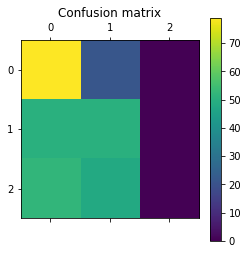

In [1]:

import cv2
import numpy as np
import os
import pylab as pl
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score #sreeni
import joblib


# Load the classifier, class names, scaler, number of clusters and vocabulary 
#from stored pickle file (generated during training)
clf, classes_names, stdSlr, k, voc = joblib.load("bovw.pkl")

# Get the path of the testing image(s) and store them in a list
test_path = 'Tensorflow/workspace/images/test_bovw'

testing_names = os.listdir(test_path)
testing_names.sort() #['mask_weared_incorrect', 'with_mask', 'without_mask']

# Get path to all images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

#To make it easy to list all file names in a directory let us define a function
#
def imglist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

#Fill the placeholder empty lists with image path, classes, and add class ID number

for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    image_list = imglist(dir)
    image_paths+=image_list
    image_classes+=[class_id]*len(image_list)
    print(testing_name, end=" ")
    print(class_id)
    class_id+=1
    
# Create feature extraction and keypoint detector objects
# Create List where all the descriptors will be stored
des_list = []

sift = cv2.xfeatures2d.SIFT_create()

for image_path in image_paths:
    im = cv2.imread(image_path)
    kpts, des = sift.detectAndCompute(im, None)
    des_list.append((image_path, des))   
    
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[0:]:
    descriptors = np.vstack((descriptors, descriptor)) 

# Calculate the histogram of features
#vq Assigns codes from a code book to observations.
from scipy.cluster.vq import vq    
test_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        test_features[i][w] += 1

# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (test_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

# Scale the features
#Standardize features by removing the mean and scaling to unit variance
#Scaler (stdSlr comes from the pickled file we imported)
test_features = stdSlr.transform(test_features)

#######Until here most of the above code is similar to Train except for kmeans clustering####

#Report true class names so they can be compared with predicted classes
true_class =  [classes_names[i] for i in image_classes]
# Perform the predictions and report predicted class names. 
predictions =  [classes_names[i] for i in clf.predict(test_features)]


###############################################
#To make it easy to understand the accuracy let us print the confusion matrix

def showconfusionmatrix(cm):
    pl.matshow(cm)
    pl.title('Confusion matrix')
    pl.colorbar()
    pl.show()


accuracy = accuracy_score(true_class, predictions)
recall = recall_score(true_class, predictions, average='micro')
precision = precision_score(true_class, predictions, average='micro')
print ("accuracy = ", accuracy)
print()
print("recall = ", recall)
print()
print("precision = ", precision)
print()
print("[[mask_weared_incorrect      -             -      ]")
print(" [         -             with_mask         -      ]")
print(" [         -                 -       without_mask ]]")
print()
cm = confusion_matrix(true_class, predictions)
print (cm)

showconfusionmatrix(cm)


Trying loading the pipeline.config...	[LOADED]

Trying restoring the checkpoint...	[RESTORED]

Trying loading the label_map...	[LOADED]

accuracy =  0.9133333333333333

recall =  0.9133333333333333

precision =  0.9133333333333333

[[mask_weared_incorrect      -             -      ]
 [         -             with_mask         -      ]
 [         -                 -       without_mask ]]

[[90 10  0]
 [ 6 91  3]
 [ 3  4 93]]


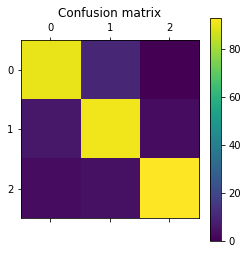

In [2]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging

import tensorflow as tf
import cv2
import numpy as np
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')  # Suppress Matplotlib warnings


tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

CUSTOM_MODEL_NAME = 'my_ssd_mobilnet'
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','exported-models', 'my_model', 'checkpoint')
 }

files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
    }

print()
# %%
# Load pipeline config and build a detection model
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("Trying loading the pipeline.config...", end='\t')
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)
print("[LOADED]")
print()

# %%
# Restore checkpoint
# ~~~~~~~~~~~~~~~~~~~~
print("Trying restoring the checkpoint...", end='\t')
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-0')).expect_partial()
print("[RESTORED]")
print()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections


# %%
# Load label map data (for plotting)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("Trying loading the label_map...", end='\t')
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'], use_display_name=True)
print("[LOADED]")
print()


def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

predictions = []

for image_path in image_paths:
    
    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    
    #return the class with the most probability
    class_id = int(detections['detection_classes'][0] + label_id_offset)
            
    predictions.append(category_index[class_id]["name"])


accuracy = accuracy_score(true_class, predictions)
recall = recall_score(true_class, predictions, average='micro')
precision = precision_score(true_class, predictions, average='micro')
print ("accuracy = ", accuracy)
print()
print("recall = ", recall)
print()
print("precision = ", precision)
print()
print("[[mask_weared_incorrect      -             -      ]")
print(" [         -             with_mask         -      ]")
print(" [         -                 -       without_mask ]]")
print()
cm = confusion_matrix(true_class, predictions)
print (cm)

showconfusionmatrix(cm)